In [ ]:
# Write only the Pyomo model display to enhanced_output.txt
import io
import sys

# Capture the model display output
old_stdout = sys.stdout
sys.stdout = buffer = io.StringIO()

enhanced_optimizer.model.display()

# Get the captured output and restore stdout
output = buffer.getvalue()
sys.stdout = old_stdout

# Write to file
with open('enhanced_output.txt', 'w') as f:
    f.write(output)

print("Model display saved to enhanced_output.txt")

# Enhanced Pharmaceutical Manufacturing Optimization
## Integration of Production and Transport Costs

This notebook extends the original pharmaceutical site selection optimization to include transport costs between vendors across sequential manufacturing steps. The enhanced model provides a more realistic cost optimization by considering the full supply chain.

In [11]:
import pyomo.environ as pyo
# Explicitly set the GLPK executable path
opt = pyo.SolverFactory('glpk',
executable='/opt/anaconda3/bin/glpsol')

import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import re

## Enhanced Production Optimizer Class

The `EnhancedProductionOptimizer` extends the original model to include:
- Transport costs between vendors in consecutive steps
- Flow consistency constraints
- Comprehensive cost breakdown (production + transport)

In [8]:
class EnhancedProductionOptimizer:
    """
    Enhanced production optimizer that incorporates both production costs and transport costs
    between vendors across sequential steps.
    
    Production CSV must have columns: [step, Vendor, Production, Cost]
    Transport CSV must have columns: [Step1, Step2, Vendor1, Vendor2, TransCost]
    """

    def __init__(self, prod_cost_csv: str, transport_cost_csv: str, demand: float):
        """
        Initialize by loading data and constructing the enhanced Pyomo model.
        
        :param prod_cost_csv: Path to CSV with columns [step, Vendor, Production, Cost]
        :param transport_cost_csv: Path to CSV with columns [Step1, Step2, Vendor1, Vendor2, TransCost]
        :param demand: Total demand that must be satisfied
        """
        # Load production data
        self.prod_df = pd.read_csv(prod_cost_csv)
        self.transport_df = pd.read_csv(transport_cost_csv)
        self.demand = demand
        
        # Process production data
        self.vendors = (
            self.prod_df
            .groupby("step")["Vendor"]
            .apply(list)
            .to_dict()
        )
        
        # (step, vendor) pairs
        self.pairs = list(self.prod_df[["step","Vendor"]]
                          .itertuples(index=False, name=None))
        
        # Production lookup dicts
        self.prod_dict = {
            (r.step, r.Vendor): r.Production
            for r in self.prod_df.itertuples()
        }
        self.cost_dict = {
            (r.step, r.Vendor): r.Cost
            for r in self.prod_df.itertuples()
        }
        
        # Process transport data
        self.transport_dict = {
            (r.Step1, r.Vendor1, r.Step2, r.Vendor2): r.TransCost
            for r in self.transport_df.itertuples()
        }
        
        # Get all transport routes (step1, vendor1, step2, vendor2)
        self.transport_routes = list(self.transport_dict.keys())
        
        # Get ordered steps
        self.ordered_steps = sorted(self.vendors.keys())
        
        # Build model
        self._build_model()
    
    def _build_model(self):
        m = pyo.ConcreteModel()
        
        # Sets
        m.steps = pyo.Set(initialize=self.vendors.keys())
        m.step_option = pyo.Set(dimen=2, initialize=self.pairs)
        m.transport_routes = pyo.Set(dimen=4, initialize=self.transport_routes)
        
        # Parameters
        m.production = pyo.Param(
            m.step_option, initialize=self.prod_dict,
            within=pyo.NonNegativeReals
        )
        m.prod_cost = pyo.Param(
            m.step_option, initialize=self.cost_dict,
            within=pyo.NonNegativeReals
        )
        m.transport_cost = pyo.Param(
            m.transport_routes, initialize=self.transport_dict,
            within=pyo.NonNegativeReals
        )
        m.demand = pyo.Param(initialize=self.demand,
                             within=pyo.NonNegativeReals)
        
        # Decision variables
        m.x = pyo.Var(m.step_option, domain=pyo.Binary)  # vendor selection
        m.y = pyo.Var(m.transport_routes, domain=pyo.Binary)  # transport route selection
        
        # Constraints
        
        # One vendor per step
        def one_per_step(mdl, step):
            return sum(mdl.x[step, v] for v in self.vendors[step]) == 1
        m.one_per_step = pyo.Constraint(m.steps, rule=one_per_step)
        
        # Production level constraint
        def prod_level(mdl):
            return sum(
                mdl.production[s, o] * mdl.x[s, o]
                for s, o in mdl.step_option
            ) >= mdl.demand
        m.prod_level = pyo.Constraint(rule=prod_level)
        
        # Only one transport route per consecutive step pair
        for i in range(len(self.ordered_steps) - 1):
            step1, step2 = self.ordered_steps[i], self.ordered_steps[i + 1]
            
            def transport_selection_rule(mdl):
                valid_routes = [
                    (s1, v1, s2, v2) for (s1, v1, s2, v2) in self.transport_routes
                    if s1 == step1 and s2 == step2
                ]
                if valid_routes:
                    return sum(mdl.y[route] for route in valid_routes) == 1
                else:
                    return pyo.Constraint.Skip
            
            setattr(m, f'transport_selection_{step1}_{step2}', 
                   pyo.Constraint(rule=transport_selection_rule))
        
        # Link transport routes to vendor selection
        for step1, vendor1, step2, vendor2 in self.transport_routes:
            def link_transport_rule(mdl):
                return mdl.y[step1, vendor1, step2, vendor2] <= mdl.x[step1, vendor1]
            
            def link_transport_rule2(mdl):
                return mdl.y[step1, vendor1, step2, vendor2] <= mdl.x[step2, vendor2]
            
            setattr(m, f'link_transport_{step1}_{vendor1}_{step2}_{vendor2}_1',
                   pyo.Constraint(rule=link_transport_rule))
            setattr(m, f'link_transport_{step1}_{vendor1}_{step2}_{vendor2}_2',
                   pyo.Constraint(rule=link_transport_rule2))
        
        # Objective: minimize production costs + transport costs
        m.obj = pyo.Objective(
            expr=sum(m.prod_cost[s, o] * m.x[s, o] for s, o in m.step_option) +
                 sum(m.transport_cost[route] * m.y[route] for route in m.transport_routes),
            sense=pyo.minimize
        )
        
        self.model = m

    def solve(self, solver='glpk', **solver_opts):
        """
        Solve the enhanced model.
        
        :param solver: Name of the Pyomo-supported solver
        :param solver_opts: Any solver-specific options to pass
        :return: Solver results object
        """
        opt = pyo.SolverFactory(solver)
        for k, v in solver_opts.items():
            opt.options[k] = v
        result = opt.solve(self.model, tee=False)
        self.model.solutions.load_from(result)
        return result

    def get_selected_options(self):
        """
        Retrieve the chosen vendor for each step.
        
        :return: dict mapping step -> selected vendor
        """
        selections = {}
        for (s, v) in self.model.step_option:
            if pyo.value(self.model.x[s, v]) > 0.5:
                selections[s] = v
        return selections

    def get_selected_transport_routes(self):
        """
        Retrieve the selected transport routes.
        
        :return: list of selected transport routes
        """
        selected_routes = []
        for route in self.model.transport_routes:
            if pyo.value(self.model.y[route]) > 0.5:
                selected_routes.append(route)
        return selected_routes

    def get_total_production_cost(self):
        """
        Compute the total production cost of the solution.
        
        :return: float
        """
        return sum(
            pyo.value(self.model.prod_cost[s, o] * self.model.x[s, o])
            for s, o in self.model.step_option
        )

    def get_total_transport_cost(self):
        """
        Compute the total transport cost of the solution.
        
        :return: float
        """
        return sum(
            pyo.value(self.model.transport_cost[route] * self.model.y[route])
            for route in self.model.transport_routes
        )

    def get_total_cost(self):
        """
        Compute the total cost (production + transport) of the solution.
        
        :return: float
        """
        return pyo.value(self.model.obj)

    def summary(self):
        """
        Print a detailed summary of results including transport routes.
        """
        selections = self.get_selected_options()
        transport_routes = self.get_selected_transport_routes()
        
        print("=== OPTIMIZATION RESULTS ===")
        print("\nSelected vendors by step:")
        for step in sorted(selections.keys()):
            vendor = selections[step]
            prod_cost = self.cost_dict[(step, vendor)]
            production = self.prod_dict[(step, vendor)]
            print(f"  Step {step}: {vendor} (Cost: ${prod_cost}, Production: {production})")
        
        print("\nSelected transport routes:")
        for step1, vendor1, step2, vendor2 in sorted(transport_routes):
            trans_cost = self.transport_dict[(step1, vendor1, step2, vendor2)]
            print(f"  Step {step1}({vendor1}) → Step {step2}({vendor2}): ${trans_cost}")
        
        print(f"\n=== COST BREAKDOWN ===")
        print(f"Total production cost: ${self.get_total_production_cost():.2f}")
        print(f"Total transport cost: ${self.get_total_transport_cost():.2f}")
        print(f"TOTAL COST: ${self.get_total_cost():.2f}")
        
        # Show the complete path
        print(f"\n=== OPTIMAL PATH ===")
        path_str = " → ".join([f"Step {s}({selections[s]})" for s in sorted(selections.keys())])
        print(f"Path: {path_str}")

## Load and Examine Data

First, let's examine the production and transport cost data to understand the structure.

In [9]:
# Load and display production data
prod_df = pd.read_csv("test-data-combo.csv")
print("Production Data:")
print(prod_df)
print("\n" + "="*50)

# Load and display transport data
transport_df = pd.read_csv("test-transport-data.csv")
print("\nTransport Data:")
print(transport_df)

Production Data:
   step Vendor  Production    Cost
0     1      A         100   30.00
1     1      B         150   45.45
2     2      A         100   30.00
3     2      B         150   45.45
4     2      C         300  150.00
5     2      D         200   25.00
6     3      X          50    5.00
7     3      Y          25    5.00


Transport Data:
    Step1  Step2 Vendor1 Vendor2  TransCost
0       1      2       A       A          0
1       1      2       A       B         50
2       1      2       A       C        100
3       1      2       A       D         75
4       1      2       B       A         25
5       1      2       B       B          0
6       1      2       B       C         75
7       1      2       B       D        100
8       2      3       A       X         33
9       2      3       B       X         66
10      2      3       C       X         12
11      2      3       D       X         50
12      2      3       A       Y         22
13      2      3       B       Y  

## Run Enhanced Optimization

Now let's solve the enhanced optimization problem that includes both production and transport costs.

In [13]:
!which glpsol

/opt/anaconda3/bin/glpsol


In [17]:
# Create and solve the enhanced optimization model
enhanced_optimizer = EnhancedProductionOptimizer(
    "test-data-combo.csv",
    "test-transport-data.csv",
    demand=100
)

# Modify the solver creation to use explicit path
opt = pyo.SolverFactory('glpk',
executable='/opt/anaconda3/bin/glpsol')
result = opt.solve(enhanced_optimizer.model, tee=False)
enhanced_optimizer.model.solutions.load_from(result)

print(f"Solver status: {result.solver.termination_condition}")
enhanced_optimizer.summary()

Solver status: optimal
=== OPTIMIZATION RESULTS ===

Selected vendors by step:
  Step 1: A (Cost: $30.0, Production: 100)
  Step 2: A (Cost: $30.0, Production: 100)
  Step 3: Y (Cost: $5.0, Production: 25)

Selected transport routes:
  Step 1(A) → Step 2(A): $0
  Step 2(A) → Step 3(Y): $22

=== COST BREAKDOWN ===
Total production cost: $65.00
Total transport cost: $22.00
TOTAL COST: $87.00

=== OPTIMAL PATH ===
Path: Step 1(A) → Step 2(A) → Step 3(Y)


## Draw graph

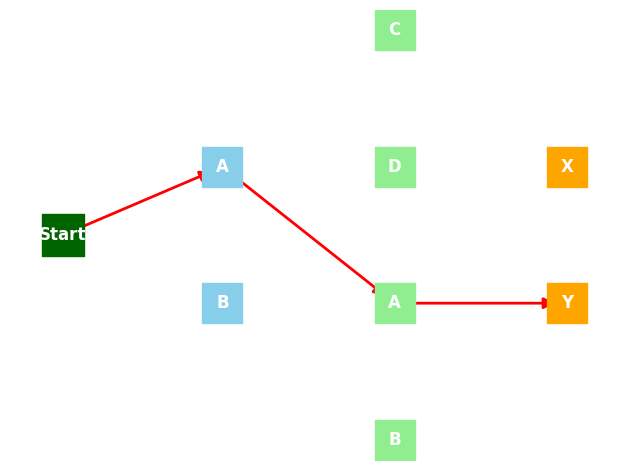

Parsed solution:
Step 1, Option A: 1.0
Step 1, Option B: 0.0
Step 2, Option A: 1.0
Step 2, Option B: 0.0
Step 2, Option C: 0.0
Step 2, Option D: 0.0
Step 3, Option X: 0.0
Step 3, Option Y: 1.0

Chosen path:
Step 1: A
Step 2: A
Step 3: Y


In [1]:
# --- 1) parse your enhanced_output.txt into solution dict -----------
import re
import networkx as nx
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout

# Pattern to match the x variables (step options) from your file
sol_pattern = re.compile(
    r"\(\s*(?P<step>\d+)\s*,\s*'(?P<option>[^']+)'\s*\)"
    r"\s*:\s*\d+\s*:\s*(?P<val>[0-9.]+)"
)

solution = {}
with open("enhanced_output.txt") as f:
    in_x_section = False
    for line in f:
        # Start reading when we hit the x variables section
        if "x : Size=" in line:
            in_x_section = True
            continue
        # Stop reading when we hit the y variables section
        elif "y : Size=" in line:
            in_x_section = False
            break
        
        # Only parse lines in the x section
        if in_x_section:
            m = sol_pattern.search(line)
            if m:
                step = int(m.group("step"))
                opt = m.group("option")
                val = float(m.group("val"))
                solution[(step, opt)] = val

# --- 2) Extract vendors dict from the solution -------------------
# Build vendors dict from the parsed solution
vendors = {}
for (step, opt), val in solution.items():
    if step not in vendors:
        vendors[step] = []
    if opt not in vendors[step]:
        vendors[step].append(opt)

# Sort steps by their numeric value
steps = sorted(vendors.keys())

# --- 3) build graph with invisible edges to force columns -------
G = nx.DiGraph()
START = 'Start'
G.add_node(START)

# add all option-nodes, keyed by (step, option)
for step in steps:
    for opt in vendors[step]:
        G.add_node((step, opt))

# invisibly chain: Step_N → Step_{N-1} → … → Step_1 → Start
for idx, step in enumerate(steps):
    targets = [START] if idx == 0 else [(steps[idx-1], o) for o in vendors[steps[idx-1]]]
    for u in vendors[step]:
        for v in targets:
            G.add_edge((step, u), v, style='invis')

# --- 4) extract chosen nodes & build the "real" edges -----------
# get (step, opt) tuples where x==1, ordered by step
chosen = sorted(
    [(st, opt) for (st, opt), val in solution.items() if val == 1],
    key=lambda x: x[0]
)

real_edges = []
# Start → first chosen
if chosen:
    real_edges.append((START, chosen[0]))
# then chain each step-to-step
for a, b in zip(chosen, chosen[1:]):
    real_edges.append((a, b))

# --- 5) layout & drawing ----------------------------------------
pos = graphviz_layout(G, prog='dot', args='-Grankdir=RL')

# draw only the real selection-path in red
nx.draw_networkx_edges(
    G, pos,
    edgelist=real_edges,
    arrowstyle='-|>',
    arrowsize=16,
    edge_color='red',
    width=2
)

# draw each "column" of nodes in its own color
# left-most = last step, …, right-most = Start
colors = ['skyblue', 'lightgreen', 'orange', 'violet', 'gold']  # cycle if you like
for idx, step in enumerate(steps):
    col = [(step, o) for o in vendors[step]]
    nx.draw_networkx_nodes(
        G, pos,
        nodelist=col,
        node_color=colors[idx % len(colors)],
        node_shape='s',
        node_size=800
    )

# finally draw the Start node
nx.draw_networkx_nodes(
    G, pos,
    nodelist=[START],
    node_color='darkgreen',
    node_shape='s',
    node_size=900
)

# labels
labels = {START: 'Start'}
labels.update({(step, o): o for step in steps for o in vendors[step]})
nx.draw_networkx_labels(G, pos, labels, font_color='white', font_weight='bold')

plt.axis('off')
plt.tight_layout()
plt.show()

# Print the solution for verification
print("Parsed solution:")
for (step, opt), val in sorted(solution.items()):
    print(f"Step {step}, Option {opt}: {val}")

print("\nChosen path:")
for step, opt in chosen:
    print(f"Step {step}: {opt}")